### Example data loading and analysis with averaged AUs

This notebook is to give a quick-start example of how to load the provided openface feature data and interpret the associated label information contained within the filenames.

Please keep in mind that openface, while a phenomenal tool, does not provide perfect coding of facial action units. 

Also keep in mind that by averaging AU levels across a large duration (i.e. the whole relevant phase in the below example), a large amount of information is being lost. Short duration events e.g. microexpressions, will likely get lost in the averaging, leaving only a small effect on the overall average.

As an alternative approach, consider the clustering example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.precision = 3
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
plt.style.use('classic')

#INPUT_FILE = '../processed_data/openface_features/voluntary_med_stakes_openface.csv.bz2'
DATASETS = ['voluntary_med_stakes', 'commanded_med_stakes', 'commanded_low_stakes']
GAZE_COLS = ['gaze_0_x','gaze_0_y', 'gaze_0_z', 
             'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
             'gaze_angle_x', 'gaze_angle_y']
POSE_COLS = ['pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz']
AU_R_COLS = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 
             'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 
             'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']
AU_C_COLS = ['AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 
             'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 
             'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c']
FPS = 15
CONFIDENCE_THRESH = 0.90

#==========================================================================================
# select a data set
# make sure you download data sets from:
# http://roc-hci.com/current-projects/deception-project/
# 'UR_LYING/v1.0/processed_data/openface_features/
# commanded_med_stakes_openface.csv.bz2
# commanded_low_stakes_openface.csv.bz2
# voluntary_med_stakes_openface.csv.bz2
# if you decompress the data file in advance (.bz2 --> .csv), you might get a load speed up
# in ubuntu, the command to decompress is $ bzip -d -k *.bz2 

df_list = []
for dataset in DATASETS:
    print('DATASET: ', dataset)
    feat_file = '../data/' + dataset + '_openface.csv'

    # load data into pandas DataFrame (this make take a while)
    df = pd.read_csv(feat_file, skipinitialspace=True)
    # the following are kinda wasteful in memory, but convenient
    df['voluntary'] = 'voluntary' in dataset
    df['med_stakes'] = 'med_stakes' in dataset
    df['dataset'] = dataset
        
    print('data loaded')
    print('df shape:', df.shape)
    print('  # data files : ', df['filename'].nunique())
    print('  # frames     : ', df.shape[0])
    print('\n------------------------------------------')
    df_list.append(df)
    
# combine
df_all = pd.concat(df_list, axis=0)
df_list = [] # to allow garbage collect
print('df shape:', df_all.shape)
print('  # data files : ', df_all['filename'].nunique())
print('  # frames     : ', df_all.shape[0])
print('\ncolumns: ')

print(df_all.columns)

DATASET:  voluntary_med_stakes
data loaded
df shape: (2179289, 56)
  # data files :  214
  # frames     :  2179289

------------------------------------------
DATASET:  commanded_med_stakes
data loaded
df shape: (1616624, 56)
  # data files :  160
  # frames     :  1616624

------------------------------------------
DATASET:  commanded_low_stakes
data loaded
df shape: (1654606, 56)
  # data files :  300
  # frames     :  1654606

------------------------------------------
df shape: (5450519, 56)
  # data files :  674
  # frames     :  5450519

columns: 
Index(['filename', 'timestamp', 'confidence', 'success', 'gaze_0_x',
       'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
       'gaze_angle_x', 'gaze_angle_y', 'pose_Tx', 'pose_Ty', 'pose_Tz',
       'pose_Rx', 'pose_Ry', 'pose_Rz', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r',
       'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r',
       'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_c'

In [3]:
# simple characteristcs of dataset
# groupby filename
g = df_all.groupby('filename')

# select which features we want to analyze
FEATURES = AU_R_COLS

mean_series_l = []
for filename, dfi in g:
    # we only want to use the relevant phase: 
    #   for the med stakes datasets, this is the last 5 minutes = 5*60*FPS frames)
    #   for the low stakes dataset, the time varies, you need to use the transcripts
    #       to determine when the relevant phase starts
    dfi = dfi.iloc[:-(5*6*FPS),:]
    # we only want to use high confidence frames
    dfi = dfi[dfi['confidence'] >= CONFIDENCE_THRESH]
    mean_series = dfi[FEATURES + ['voluntary', 'med_stakes']].mean()
    mean_series['file_id'] = '-'.join(filename.split('-')[:-3])
    mean_series['file_type'] = '-'.join(filename.split('-')[-3:-1])
    mean_series['person_id'] = filename.split('-')[-1].split('_')[0]
    mean_series['dataset'] = dfi.loc[dfi.index[0],'dataset']
    mean_series_l.append(mean_series)
df_mean = pd.concat(mean_series_l,axis=1).T
df_mean[FEATURES + ['voluntary', 'med_stakes']] = \
    df_mean[FEATURES + ['voluntary', 'med_stakes']].astype(float) # why is this needed?
#display(df_mean)
g_mean = df_mean.groupby('file_type')
print('DATASET:', dataset)
print('mean AU levels by participant type')
display(g_mean.mean())

print('  # unique participants: ', df_mean['person_id'].nunique())
print('  by dataset: ')
df_mean.groupby('dataset')['person_id'].nunique()

DATASET: commanded_low_stakes
mean AU levels by participant type


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,voluntary,med_stakes
file_type,,,,,,,,,,,,,,,,,,,
I-B,0.271,0.132,0.387,0.081,0.496,0.603,0.085,0.540,0.684,0.807,0.223,0.663,0.151,0.181,0.762,0.564,0.271,0.341,0.589
I-T,0.277,0.130,0.478,0.076,0.440,0.499,0.084,0.460,0.594,0.730,0.202,0.589,0.143,0.168,0.719,0.567,0.257,0.289,0.513
W-B,0.263,0.132,0.463,0.093,0.460,0.607,0.090,0.494,0.673,0.661,0.217,0.649,0.155,0.194,0.831,0.606,0.284,0.341,0.589
W-T,0.269,0.132,0.415,0.091,0.430,0.588,0.084,0.487,0.621,0.673,0.223,0.640,0.145,0.181,0.796,0.595,0.290,0.289,0.513


  # unique participants:  192
  by dataset: 


dataset
commanded_low_stakes    143
commanded_med_stakes     20
voluntary_med_stakes     29
Name: person_id, dtype: int64

DATASET: commanded_low_stakes
AVERAGED AU distributions from the relevant questioning phase


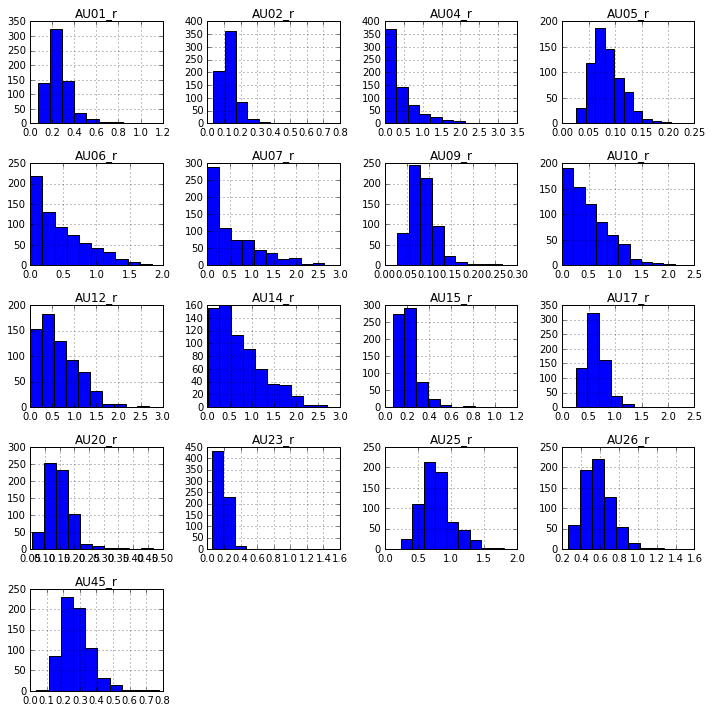

In [7]:
# How are the averaged FEATURES DISTRIBUTED?
print('DATASET:', dataset)
print('AVERAGED AU distributions from the relevant questioning phase')
df_mean[FEATURES].hist(figsize=(10, 10))
plt.tight_layout()
plt.show()


DATASET: commanded_low_stakes


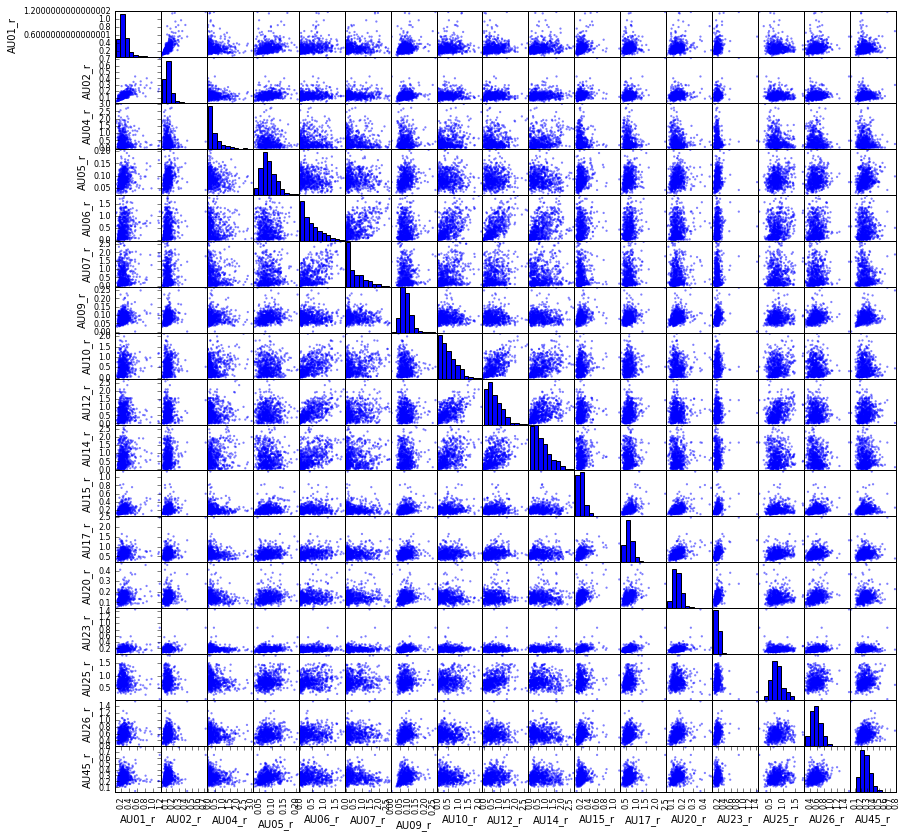

In [5]:
from pandas.plotting import scatter_matrix
print('DATASET:', dataset)
scatter_matrix(df_mean[FEATURES], alpha=0.5, figsize=(14, 14))
plt.show()

In [8]:
# Are there statistically significant differences between W-B and W-T?
from scipy.stats import ttest_ind
import numpy as np

df_WT = df_mean[df_mean['file_type'] == 'W-T']
df_WB = df_mean[df_mean['file_type'] == 'W-B']

pvals = pd.Series(np.zeros(len(FEATURES)))
pvals.index = FEATURES
for feat in FEATURES:
    tstat, p = ttest_ind(df_WT[feat], df_WB[feat])
    pvals[feat] = p
pval_df = pd.DataFrame(pvals).T
pval_df.index = ['p-val']
print('DATASET:', dataset)
print('t-test comparison between W-T and W-B of average relevant phase AUs')
display(pval_df)


DATASET: commanded_low_stakes
t-test comparison between W-T and W-B of average relevant phase AUs


,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
p-val,0.56,0.935,0.399,0.685,0.493,0.771,0.131,0.862,0.286,0.832,0.61,0.696,0.087,0.255,0.205,0.561,0.605


### Simple classification example

Here we see if the average AUs from the relevant phase can be used to classify between honest and dishonest witnesses.

Note that the following is an overly simplistic example. At a minimum, one should properly select hyperparameters and control the test, train, and dev sets such that the same participants do not appear in more than one group.



In [9]:
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn import svm, linear_model, tree, neighbors

print('DATASET:', dataset)
print('classification between W-T and W-B using average relevant phase AUs\n')

X = pd.concat([df_WT[FEATURES], df_WB[FEATURES]], axis=0)
print('X.shape', X.shape)
y = np.hstack([np.ones(df_WT.shape[0]), np.zeros(df_WB.shape[0])])

print('\nQuick and dirty machine learning model performance:')
print('   -without hyperparameter optimization')
print('   -without ensuring test and train set don\'t have same people\n')
print('10 fold cross validated average accuracy:\n')

clf = linear_model.LogisticRegression(C=1, penalty='l2')
scores = cross_val_score(clf, X, y, cv=10)
print('\nlogit accuracy: ', scores.mean())

clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf, X, y, cv=10)
print('dec tree accuracy: ', scores.mean())

clf = neighbors.KNeighborsClassifier()
scores = cross_val_score(clf, X, y, cv=10)
print('nneighbors accuracy: ', scores.mean())

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, y, cv=10)
print('svm(linear) accuracy:   ', scores.mean())

clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X, y, cv=10)
print('svm(rbf) accuracy:   ', scores.mean())



DATASET: commanded_low_stakes
classification between W-T and W-B using average relevant phase AUs

X.shape (337, 17)

Quick and dirty machine learning model performance:
   -without hyperparameter optimization
   -without ensuring test and train set don't have same people

10 fold cross validated average accuracy:


logit accuracy:  0.5034122740005093
dec tree accuracy:  0.5318029029793736
nneighbors accuracy:  0.4660224089635854
svm(linear) accuracy:    0.5277336389101095
svm(rbf) accuracy:    0.5489457601222307
